In [1]:
 # from PIL import Image

# rootdir = 'images'

# index = 0
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         img = Image.open(os.path.join(subdir, file)).convert('L')
#         img.save('grayscale/' + str(index) + '.jpg')
#         index += 1

# import shutil
# shutil.make_archive("images", 'zip', "grayscale")

# from PIL import Image

# rootdir = 'images'

# # index = 0
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         # img = Image.open(os.path.join(subdir, file)).convert('L')
#         img = Image.open(os.path.join(subdir, file)).resize((92, 112))
#         img.save(os.path.join(subdir, file))
#         # index += 1

# import shutil
# shutil.make_archive("images", 'zip', "images")

In [2]:
# from zipfile import ZipFile

# file_name = "faces.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

# file_name = "images.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [3]:
import os
from collections import Counter
import math
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [4]:
def euclidean_distance(sample1, sample2):
    sum_squared_distance = 0
    for i in range(len(sample1)):
        sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
    return math.sqrt(sum_squared_distance)

In [5]:
def knn_classifier(data, train_labels, queries, k):

  data = pd.DataFrame(data=data)
  data[-1] = train_labels
  data = data.to_numpy().tolist()

  predictions = []
  for query in queries:
      neighbor_distances_and_indices = []
      
      for index, example in enumerate(data):
          distance = euclidean_distance(example[:-1], query)
          neighbor_distances_and_indices.append((distance, index))
      
      sorted_neighbor_distances_and_indices = sorted(neighbor_distances_and_indices)        
      k_nearest_distances_and_indices = sorted_neighbor_distances_and_indices[:k]        
      k_nearest_labels = [data[i][-1] for distance, i in k_nearest_distances_and_indices]
      predictions.append(Counter(k_nearest_labels).most_common(1)[0][0])
  
  return predictions

In [6]:
def accuracy(y_true, y_pred):
    correct = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            correct += 1
    return correct / len(y_true)

In [7]:
number_of_classes = 2

rootdir = 'faces'
faces = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        faces.append(cv.imread(os.path.join(subdir, file), cv.IMREAD_GRAYSCALE))

faces = np.array(faces)

rootdir = 'images'
non_faces = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        non_faces.append(cv.imread(os.path.join(subdir, file), cv.IMREAD_GRAYSCALE))

non_faces = np.array(non_faces)

In [8]:
samples = 350
face_samples = 200
dimensions = 10304

data = np.zeros((samples, dimensions))

i = 0
for face in faces:
    data[i] = face.reshape((1, -1))
    i += 1

i = face_samples
for non_face in non_faces[:(samples - face_samples)]:
    data[i] = non_face.reshape((1, -1))
    i += 1

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [10]:
# 50 - 50 data separation

# # variable
# training_samples = samples - 200 
# # variable
# class1_samples_training = training_samples // 2
# # variable
# class2_samples_training = training_samples // 2

# # constant
# testing_samples = 200
# # constant 
# class1_samples_testing = 100
# # constant 
# class2_samples_testing = 100

# # 70 - 30 data separation

# training_samples = 280 # 140 faces and 140 non faces
# testing_samples = 120 # 60 faces and 60 non faces
# training_samples_per_class = 140
# testing_samples_per_class = 60

In [11]:
# 50 - 50 data separation
def train_test_split_1():
  test = []
  # 0 -> 100
  for i in range(0, 100):
    test.append(data[i].tolist())
  for i in range(200, 300):
    test.append(data[i].tolist())
  train = []
  for i in range(100, 200):
    train.append(data[i].tolist())
  for i in range(300, samples):
    train.append(data[i].tolist())
  return train, test

In [12]:
# 70 - 30 data separation
def train_test_split_2():
  train = []
  for i in range(140):
    train.append(data[i].tolist())
  for i in range(200,340):
    train.append(data[i].tolist())
  test = []
  for i in range(140,200):
    test.append(data[i].tolist())
  for i in range(340,400):
    test.append(data[i].tolist())
  return train, test

In [13]:
def find_n(alpha_s, eig_vals):
  n = []
  eigen_values = eig_vals.tolist()
  summation = sum(eigen_values)
  for i in range(len(alpha_s)):
    temp = alpha_s[i]
    temp *= summation
    n_components = 0
    l = 0
    while l < temp:
      l += eigen_values[n_components]
      n_components += 1
    n.append(n_components)
  return n

In [14]:
# 50 - 50 data separation
training_data, testing_data  = train_test_split_1()
X_train, X_test  = train_test_split_1()

# # 70 - 30 data separation
# training_data, testing_data = train_test_split_2()
# X_train, X_test = train_test_split_2()

In [15]:
def get_labels(spc):
  labels = []
  for i in range(number_of_classes):
      for j in range(spc[i]):
          labels.append(i+1)
  return labels

train_labels = get_labels([100, (samples - 200 - 100)])
test_labels = get_labels([100, 100])

In [16]:
# PCA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

ns = [39, 56, 82, 128]
for n in ns:
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(training_data)
  X_test_pca = pca.transform(testing_data)

  classifier = KNeighborsClassifier(n_neighbors=1)
  classifier.fit(X_train_pca, train_labels)
  score = classifier.score(X_test_pca, test_labels)

  print(f"Test accuracy: {score}")

Test accuracy: 0.92
Test accuracy: 0.895
Test accuracy: 0.87
Test accuracy: 0.875


In [17]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy.linalg import pinv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

lda = LinearDiscriminantAnalysis(n_components=number_of_classes - 1)
X_train_lda = lda.fit_transform(training_data, train_labels)
X_test_lda = lda.transform(testing_data)

X_reconstructed = np.dot(X_test_lda, pinv(lda.scalings_)) + lda.xbar_

for k in [1, 3, 5, 7]:
  classifier = KNeighborsClassifier(n_neighbors=1)
  classifier.fit(X_train_lda, train_labels)
  score = classifier.score(X_test_lda, test_labels)

  print(f"Test accuracy: {score}")

Test accuracy: 0.905
Test accuracy: 0.905
Test accuracy: 0.905
Test accuracy: 0.905


In [18]:
# LDA
training_data = [training_data[:100], training_data[100:]]
testing_data = [testing_data[:100], testing_data[100:200]]

In [19]:
# LDA
s_w = np.zeros(shape=(dimensions, dimensions))

for i, j in zip(range(2), [100, samples - 200 - 100]):
  s_w += np.cov(training_data[i], rowvar=False, bias=True)*j

s_w

array([[6.20563337, 6.14057578, 5.74201968, ..., 3.13206526, 3.24827079,
        3.31839603],
       [6.14057578, 6.44699823, 6.04760969, ..., 3.1582556 , 3.31210044,
        3.39288662],
       [5.74201968, 6.04760969, 6.39077078, ..., 2.95800403, 2.95568767,
        3.02810261],
       ...,
       [3.13206526, 3.1582556 , 2.95800403, ..., 5.1912767 , 5.23461935,
        5.07806465],
       [3.24827079, 3.31210044, 2.95568767, ..., 5.23461935, 5.44584496,
        5.29638957],
       [3.31839603, 3.39288662, 3.02810261, ..., 5.07806465, 5.29638957,
        5.29981596]])

In [20]:
# LDA
mean1 = np.mean(training_data[0], axis=0)
mean2 = np.mean(training_data[1], axis=0)
s_b = np.array([(mean1 - mean2).tolist()]).T @ np.array([(mean1 - mean2).tolist()])
s_b

array([[0.05940211, 0.05390634, 0.05477611, ..., 0.09948431, 0.09526488,
        0.09282762],
       [0.05390634, 0.04891903, 0.04970833, ..., 0.09028021, 0.08645115,
        0.08423939],
       [0.05477611, 0.04970833, 0.05051036, ..., 0.09173686, 0.08784602,
        0.08559857],
       ...,
       [0.09948431, 0.09028021, 0.09173686, ..., 0.1666124 , 0.15954585,
        0.15546403],
       [0.09526488, 0.08645115, 0.08784602, ..., 0.15954585, 0.15277902,
        0.14887032],
       [0.09282762, 0.08423939, 0.08559857, ..., 0.15546403, 0.14887032,
        0.14506163]])

In [21]:
# # PCA
# A = np.cov(training_data, rowvar=False, bias=True)

In [22]:
# LDA
A = np.linalg.inv(s_w) @ s_b

In [23]:
# # PCA symmetric matrix
# eig_vals, eig_vecs = np.linalg.eigh(A)

In [24]:
# LDA non symmetric matrix
eig_vals, eig_vecs = np.linalg.eig(A)

In [25]:
idxs = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idxs]
eig_vecs = eig_vecs[:, idxs]

In [26]:
# # PCA
# alpha_s = np.array([0.8, 0.85, 0.9, 0.95])
# n = find_n(alpha_s, eig_vals)

In [27]:
# LDA
n = [number_of_classes - 1]

In [28]:
def transform_data(n):
  projection_matrix = eig_vecs[:, 0:n]
  transformed_train = X_train @ projection_matrix
  transformed_test = X_test @ projection_matrix
  return transformed_train, transformed_test

In [29]:
def find_accuracy(n_features, tuning_k):
  score = []
  classified_labels = []
  transformed_train, transformed_test = transform_data(n_features)
  for k in tuning_k:
    current_classified_labels = knn_classifier(transformed_train, train_labels, transformed_test, k)
    classified_labels.append(current_classified_labels)
    score.append(accuracy(test_labels, current_classified_labels))
  return score, classified_labels

In [30]:
# tuning_k = [1, 3, 5, 7]
n = [25]
tuning_k = [1]
scores = [find_accuracy(n_features, tuning_k)[0] for n_features in n]

print('-------------------------------')
index = 0
for score in scores:
  print('[n_components = ', n[index],']')
  print('-------------------------------')
  for j in range(len(score)):
    print('tuning_k = ', tuning_k[j])
    print(score[j])
  print('-------------------------------')
  index += 1

-------------------------------
[n_components =  1 ]
-------------------------------
tuning_k =  1
0.595
-------------------------------


<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)


<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)
<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.

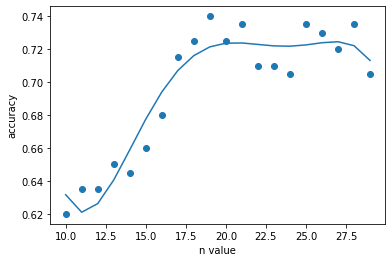

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

predictions = [[],[],[],[]]
nc_s = [i for i in range(10, 30)]
nc_sl = [[i] for i in nc_s]
y = []

for n_features in nc_s:
  y.append(find_accuracy(n_features, [1])[0][0])

# Transform the data to include polynomial features
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(nc_sl)

# Create a LinearRegression model and fit it to the transformed data
model = LinearRegression()
model.fit(X_poly, y)

# Make predictions using the fitted model
predictions = model.predict(X_poly)

# Plot the data and the predictions
plt.scatter(nc_sl, y)
plt.plot(nc_sl, predictions)

# Add x and y labels
plt.xlabel('n value')
plt.ylabel('accuracy')

plt.show()


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

predictions = [[],[],[],[]]
ks = [i for i in range(1, 11)]
ksl = [[i] for i in ks]
y = [[],[],[],[]]

index = 0
for n_features in n:

  y[index] = find_accuracy(n_features, ks)[0]

  # Transform the data to include polynomial features
  poly = PolynomialFeatures(degree=7)
  X_poly = poly.fit_transform(ksl)

  # Create a LinearRegression model and fit it to the transformed data
  model = LinearRegression()
  model.fit(X_poly, y[index])

  # Make predictions using the fitted model
  predictions[index] = model.predict(X_poly)
  index += 1

# Plot the data and the predictions
colors = ['blue','orange','green','red']
for i in range(len(n)):
  plt.scatter(ksl, y[i], color=colors[i])
  plt.plot(ksl, predictions[i], color=colors[i], label='n='+str(n[i]))

  # Add x and y labels
  plt.xlabel('k value')
  plt.ylabel('accuracy')

  # Add a legend
  plt.legend(loc='best')
  plt.show()


In [33]:
import matplotlib.pyplot as plt

def reconstruction(n_features, k):
  k = [k]
  inverse_projection_matrix = eig_vecs[:, 0:n_features].T
  score, result_labels = find_accuracy(n_features, k)
  image_reconstructed = np.dot(transform_data(n_features)[1], inverse_projection_matrix)

  image_shape = faces[0].shape
  n_row, n_col = 10, 20
  n_faces = n_row * n_col

  def plot_gallery(images):
      plt.figure(figsize=(2. * n_col, 2.26 * n_row))
      for i in range(n_faces):
        text = ""
        if result_labels[0][i] == 1:
          text = "face"
        else:
          text = "non face"
        plt.subplot(n_row, n_col, i + 1).set_title(text)
        plt.imshow(images[i].reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

  plot_gallery(image_reconstructed)
  plt.show()

In [34]:
import matplotlib.pyplot as plt

def reconstruction(n_features, k):
  k = [k]
  score, result_labels = find_accuracy(n_features, k)

  image_shape = faces[0].shape
  n_row, n_col = 10, 20
  n_faces = n_row * n_col

  def plot_gallery(images):
      plt.figure(figsize=(2. * n_col, 2.26 * n_row))
      for i in range(n_faces):
        text = ""
        if result_labels[0][i] == 1:
          text = "face"
        else:
          text = "non face"
        plt.subplot(n_row, n_col, i + 1).set_title(text)
        plt.imshow(images[i].reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

  plot_gallery(np.array(X_test))
  plt.show()

In [35]:
print("------------------------------------ n = " + str(n[0]) +  " -------------------------------------")
reconstruction(n[0], k=1)


Output hidden; open in https://colab.research.google.com to view.

<ipython-input-4-e7030aee6cca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_squared_distance += math.pow(sample1[i] - sample2[i], 2)


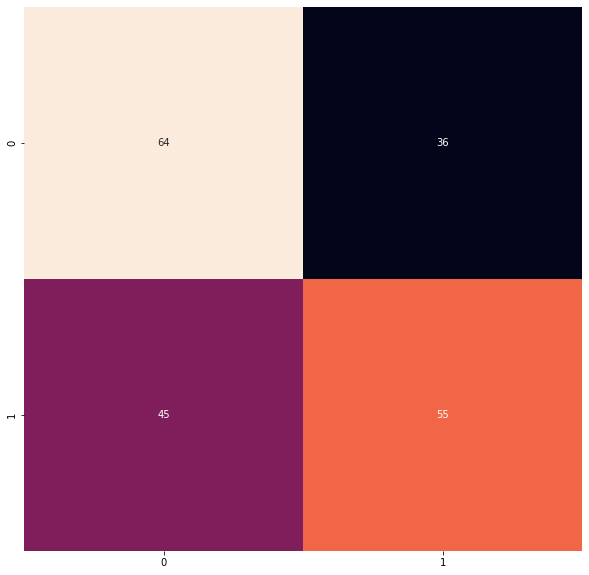

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

temp = np.array(find_accuracy(n[0], [1])[1]).T.squeeze()
temp = [x.real for x in temp]
cmatrix = confusion_matrix(test_labels, temp)

plt.figure(figsize=(10, 10))
sns.heatmap(cmatrix, annot=True, cbar=False)
plt.show()

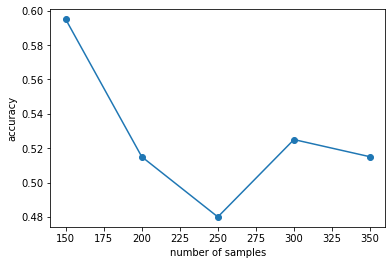

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

predictions = [[],[],[],[]]
nc_s = [150, 200, 250, 300, 350]
nc_sl = [[i] for i in nc_s]
# s = [0.9657, 0.95, 0.9467, 0.92, 0.917]
# s = [0.9714, 0.965, 0.9511, 0.9314, 0.9]
# s = [0.925, 0.96, 0.97, 0.955, 0.945, 0.925]
s = [0.595, 0.515, 0.48, 0.525, 0.515]

# Transform the data to include polynomial features
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(nc_sl)

# Create a LinearRegression model and fit it to the transformed data
model = LinearRegression()
model.fit(X_poly, s)

# Make predictions using the fitted model
predictions = model.predict(X_poly)

# Plot the data and the predictions
plt.scatter(nc_sl, s)
plt.plot(nc_sl, predictions)

# Add x and y labels
plt.xlabel('number of samples')
plt.ylabel('accuracy')

plt.show()


In [40]:
# PCA
# SAMPLES = 250
# ALPHA = 0.8
# N = 25
# ACC = 9.467

# SAMPLES = 300
# ALPHA = 0.8
# N = 26
# ACC = 0.92

# SAMPLES = 350 
# ALPHA = 0.8
# N = 28
# ACC = 0.9236

# SAMPLES = 150
# ALPHA = 0.8
# N= 21
# ACC= 0.9657


# LDA 
# SAMPLES = 150
# N = 18
# ACC = 0.9714

# SAMPLES 250 
# N = 25
# ACC = 0.9511

# samples = 300
# n = 12
# acc = 0.9

# samples = 350
# n = 25
# acc = 0.9527